### Created by David Cruz 
### Github: dcruz083

### Project for Florida Atlantic University - CAP6673

### Finalized on Nov 19th 2023

# 1. Exploratory Data Analysis (EDA):

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import numpy as np
import matplotlib.pyplot as plt


In [6]:
#paths to train and test directories
train_dir = 'Alzheimer_sDataset/train'
test_dir = 'Alzheimer_sDataset/test'

In [7]:
# Defining the image data generator for both training and testing 
datagen = ImageDataGenerator(rescale=1./255)

# Setting the batch size
batch_size = 32

# Create generators for training and testing data(without data augmentation, just rescaling)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Retrieving the class labels
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Class labels: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Train Images


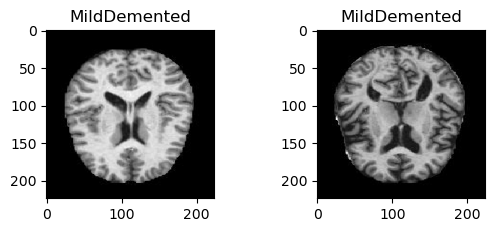

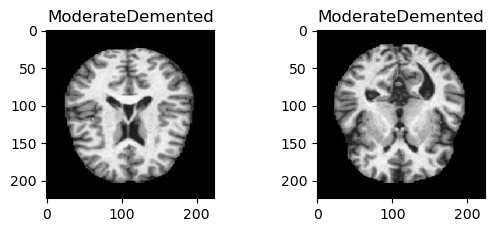

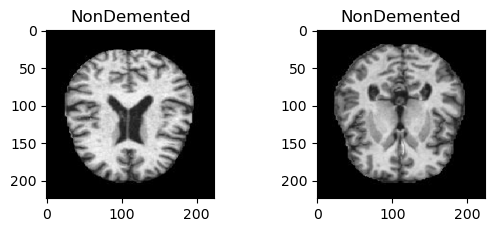

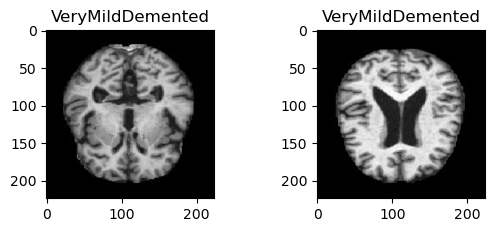

In [42]:
#Visualize different classes of train set images to identify distinguishing features
print('Train Images')
for i, class_label in enumerate(class_labels):
    # Loading the next batch of images
    batch = train_generator.next()
    
    # Extract the images and labels from the batch
    images, labels = batch
    
    # Display two images from the current class
    for j in range(2):
        plt.subplot(2, 2, j+1)
        plt.imshow(images[j])
        #plt.title(f'{class_label} - {class_labels[np.argmax(labels[j])]}')
        plt.title(f'{class_label}')
        plt.axis()
    
    plt.show()

# 2. Data Preprocessing

In [55]:
# Create an ImageDataGenerator with resizing, normalization and augmentation
datagen_preprocess = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,        # Normalization. Normalize pixel values to be between 0 and 1
    shear_range=40,       # Shear transformation
    zoom_range=0.3,        # Zoom transformation
    horizontal_flip=True,  # Horizontal flip
    rotation_range=90,     # Rotation range in degrees
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2 # Vertical shift
)

# Create generators for training and testing data
train_generator = datagen_preprocess.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_generator = datagen_preprocess.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


Train Images - Normalized, Resized, and Augmented


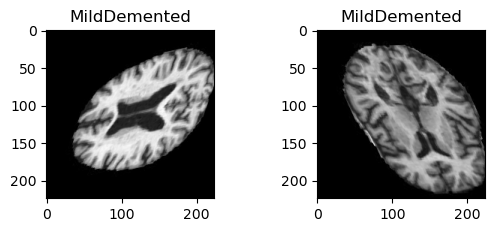

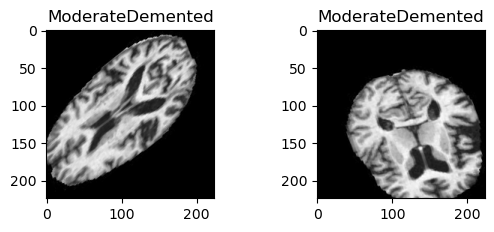

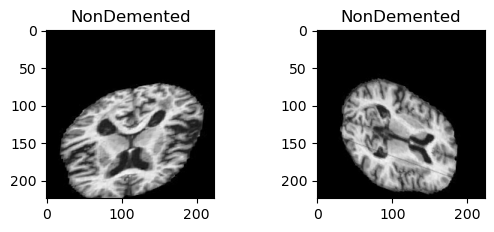

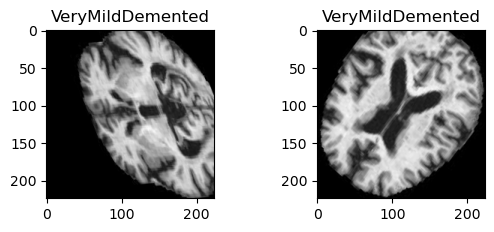

In [63]:
#Visualize different classes of augmented train set images to identify distinguishing features
print('Train Images - Normalized, Resized, and Augmented')
for i, class_label in enumerate(class_labels):
    # Loading the next batch of images
    batch = train_generator.next()
    
    # Extract the images and labels from the batch
    images, labels = batch
    
    # Display two images from the current class
    for j in range(2):
        plt.subplot(2, 2, j+1)
        plt.imshow(images[j])
        #plt.title(f'{class_label} - {class_labels[np.argmax(labels[j])]}')
        plt.title(f'{class_label}')
        plt.axis()
    
    plt.show()

# 3. Model Selection and Training
## Transfer Learning Model
#### Utilize a pre-trained model and fine-tune it for the Alzheimer's MRI image dataset.

In [19]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [13]:
#function to evaluate each model
def evaluateModel(model, test):
    #evaluate the model
    loss, accuracy = model.evaluate(test)
    return loss, accuracy

In [31]:
# Load VGG16 pre-trained on ImageNet, excluding the top classification layer
#VGG-16 is a convolutional neural network that is 16 layers deep. 
#The pretrained network can classify images into 1000 object categories.

#Previous studies where VGG-16 achieved 99.08% F1-Score for MRI Image Classification
#https://www.frontiersin.org/articles/10.3389/fnhum.2023.1150120/full
transfer_learning_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in transfer_learning_model.layers:
    layer.trainable = False

#ceating a new model on top of the pre-trained tansfer learning model
model = Sequential()
model.add(transfer_learning_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

#compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#train the model with the train_generator dataset
model.fit(train_generator, epochs=10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
161/161 [==============

In [159]:
model_loss, model_accuracy = evaluateModel(model, test_generator)
print('Accuracy for transfer learning model: ', model_accuracy)

2023-11-18 09:57:40.468325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 678s 17s/step - loss: 1.0330 - accuracy: 0.5004
Accuracy for transfer learning model:  0.5003909468650818


## Custom Deep Neural Network (DNN)
#### Construct and train a DNN from scratch specifically tailored for this dataset.

In [50]:
# Define the model architecture

model2 = Sequential([
    Flatten(input_shape=(224, 224, 3)), # Input layer: Flattens the input (images of size 224x224x3)
    Dense(512, activation='relu'), # Hidden layer with 512 neurons and ReLU activation
    Dense(256, activation='relu'),      # Hidden layer with 256 neurons and ReLU activation
    Dropout(0.25),                # Dropout layer with a dropout rate of 0.25 to prevent overfitting
    Dense(128, activation='relu'),      # Hidden layer with 128 neurons and ReLU activation
    Dense(64, activation='sigmoid'),    # Hidden layer with 64 neurons and Sigmoid activation
    Dropout(0.25),
    Dense(32, activation='sigmoid'),    # Hidden layer with 32 neurons and Sigmoid activation
    Dense(4, activation='softmax')      # Output layer with 4 neurons (assuming 4 classes) and softmax activation
])
# Compile the model
model2.compile(optimizer='adam',  # Using Adam optimizer
              loss='categorical_crossentropy',      # Categorical cross-entropy loss for multi-class classification
              metrics=['accuracy']) # Track accuracy during training

# Display the model summary
model2.summary()

model2.fit(train_generator,epochs=15,validation_data=val_generator)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 150528)            0         
                                                                 
 dense_41 (Dense)            (None, 512)               77070848  
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dropout_25 (Dropout)        (None, 64)              

In [51]:
model_loss, model_accuracy = evaluateModel(model2, test_generator)
print('Accuracy for custom DNN model: ', model_accuracy)

40/40 [==============================] - 1s 34ms/step - loss: 1.0348 - accuracy: 0.5004
Accuracy for custom DNN model:  0.5003909468650818


## Self-Designed Model 
#### Design and train an original model, justifying the architecture and parameter choices.

In [52]:
"""
# Custom CNNs for this design
# CNNs tends to be the most successful technique in image processing,
# as they have many layes and high diagnostic accuracy for MRI data. 
"""

# Defining the model architecture. 
model3 = Sequential([
    
    #Starting the model with convolutional layers 
    #Increasing the filter depth to allow the model to learn hierarchical features.
    #Using max polling to help indentify the most distivice features of MRI dataset
    
    #Using ReLu activation function to help overcome the vanishing gradient problem, 
    #which is a common issue in deep networks.
    #The other benefit of ReLUs is sparsity. 
    #The more such units that exist in a layer the more sparse the resulting representation.
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters, kernel size 3x3
    MaxPooling2D((2, 2)),  # Max pooling layer with pool size 2x2
    
    #Continue to use kernel size 3x3 to reduce computational cost. 
    #The role of kernel is to take advantage of the spatial structure of input data. 
    #That is what the kernel does by considering the pixel and all his direct neighbours in the receptive field (3x3 receptive field).
    #A 3x3 kernel is how the network "understand" that the input is a 2d image.
    
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters, kernel size 3x3
    MaxPooling2D((2, 2)),  # Max pooling layer with pool size 2x2
    
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters, kernel size 3x3
    MaxPooling2D((2, 2)),  # Max pooling layer with pool size 2x2
    
    Flatten(),  # Flatten layer to transition from convolutional layers to dense layers
    
    # Dense layers are used to classify image based on output from convolutional layers.
    # The number of neurons decreases gradually to prevent overfitting.
    
    # The primary advantage of dense layers is that they are able to capture complex patterns in data,
    # by allowing each neuron to interact with all the neurons in the previous layer
    
    Dense(256, activation='relu'),  # Dense layer with 256 neurons and ReLU activation
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    
    Dense(128, activation='relu'),  # Dense layer with 128 neurons and ReLU activation
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    
    Dense(4, activation='softmax')  # Output layer with 4 neurons (assuming 4 classes) and softmax activation
])

# Compile the model
model3.compile(optimizer='adam',  # Using Adam optimizer
              loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
              metrics=['accuracy'])  # Track accuracy during training

# Display the model summary
model3.summary()

#train the model with the train_generator dataset
model3.fit(train_generator, epochs=10, validation_data=val_generator)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 128)    

In [53]:
model_loss, model_accuracy = evaluateModel(model3, test_generator)
print('Accuracy for student desinged model: ', model_accuracy)

40/40 [==============================] - 6s 154ms/step - loss: 0.9163 - accuracy: 0.5520
Accuracy for student desinged model:  0.551993727684021


# 4. Model Evaluation
## Compare the performance of the three models based on accuracy, precision, recall, and F1-score.

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [59]:
def model_evaluation(model, test_generator):

    # Getting and Converting predictions to class labels
    y_pred = np.argmax(model.predict(test_generator), axis=1)

    # Get true labels from the validation generator
    y_true = test_generator.classes
    
    print(classification_report(y_true, y_pred, target_names=class_labels))

In [60]:
print('\nTransfer Learning Model Evaluation:')
model_evaluation(model, test_generator)
print('\nCustom DNN Model Evaluation:')
model_evaluation(model2, test_generator)
print('\nStudent design Model Evaluation:')
model_evaluation(model3, test_generator)


Transfer Learning Model Evaluation:
40/40 [==============================] - 125s 3s/step
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.51      0.98      0.67       640
VeryMildDemented       0.51      0.06      0.10       448

        accuracy                           0.51      1279
       macro avg       0.26      0.26      0.19      1279
    weighted avg       0.44      0.51      0.37      1279


Custom DNN Model Evaluation:
 3/40 [=>............................] - ETA: 1s

/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

40/40 [==============================] - 1s 35ms/step
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      1.00      0.67       640
VeryMildDemented       0.00      0.00      0.00       448

        accuracy                           0.50      1279
       macro avg       0.13      0.25      0.17      1279
    weighted avg       0.25      0.50      0.33      1279


Student design Model Evaluation:


/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

40/40 [==============================] - 6s 151ms/step
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.64      0.77      0.70       640
VeryMildDemented       0.42      0.47      0.45       448

        accuracy                           0.55      1279
       macro avg       0.26      0.31      0.29      1279
    weighted avg       0.47      0.55      0.51      1279



/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidcruz/anaconda3/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

## Analyze the strengths and weaknesses of each model in terms of training time, performance, and generalizability

#### One advantage of the transfer learning model is that it saves training time, delivers better performance of neural networks (in most cases), and requires less data. However, one weakness of the model is its long training time. On the other hand, the other two models require extensive knowledge of neural network design, which can be both a strength and a weakness. For those active in the field of ML/DL, this provides more control over how to construct and build DNNs from scratch. But, it requires some design, discovery and learning prior to deciding on HOW to construct the neural network. 

#### The transfer learning model took almost 8 hours to train initially, while the other two models took only 30 minutes to an hour. After switching to train on GPU, the transfer learning model still took the longest time, averaging about an hour, compared to the other models that trained within 5-15 minutes. 

#### In terms of performance, both the transfer learning and custom DNN models had the lowest accuracy compared to my desined convolutional network. They scored 51%, 50%, and 54% respectively. With transfer learning and Custom DNN, there was a bias towards the NonDemented class, while the convolutional network gravitated towards both. None of the three models obtained an impactful score for MildDemented and ModerateDemented classes. This signifies an issue in the training or dataset. 

#### Generalizability is defined as the ability of a model to perform its purpose on data from a new, independent cohort of patients, i.e., patients whose data were never used during the development process. It is akin to the external validation of a model. None of the three models satisfy this definition, which means they may not have learned the true relationship between the features and the target outcome, but instead, may have learned consequent biases from data generation and processing protocols. This makes it harder to reproduce results when deploying in practice and produce accurate results in general.

# 4. Discussion and Conclusion
## Discuss the results and provide insights into the behavior of the different models with this particular dataset.

#### From the results obtained, it is clear that the transfer learning model has some advantages over the other two models, such as saving designing time, easy to “plug” into and requiring less data. However, its long training time can also be seen deter novices to construct models that require less computational cost. 
#### When it comes to accuracy, my designed convolutional network outperformed both the transfer learning and custom DNN models. It scored 54%, which was higher than the 51% and 50% scored by the transfer learning and custom DNN models respectively. 
#### In the results obtained, the CNN model achieved 54% accuracy and a F1-score of 0.51, improving the results of the other two models.
#### It's also worth noting that there was a bias towards the NonDemented class in all three models, while the convolutional network also gravitated towards both the NonDemented and VeryMildDemented classes. None of the three models obtained an impactful score for the MildDemented and ModerateDemented classes, which is a cause for concern. This could be a sign of overfitting or an issue in the training or dataset.
#### Based on the support for each class, the two classes(NonDemented and VeryMildDemented) tend to have the bigger datasets while the other  contain much less examples. This is a sign of imbalanced data thus leading creating bias to the classes with more examples.  
#### Overall, these insights into the behavior of the different models are crucial in helping researchers and practitioners fine-tune their models and datasets to achieve better results in the future and deploying to production. 

## Conclude with recommendations on the most effective model for predicting the stages of Alzheimer’s disease.

#### Alzheimer's disease is a severe neurodegenerative disorder that affects millions of people worldwide. Convolutional neural network is a popular method used to predict the different stages of the disease accurately. Based on the three models performance, my designed CNN performed the highest of all three models, thus making ideal for predicting the stages of Alzheimer’s disease. However, before deploying the model, it is essential to take a closer look at the MRI dataset.

#### The MRI dataset contains various classes that represent the different stages of Alzheimer's disease. Nevertheless, an imbalance exists between these classes. This imbalance could lead to poor model performance, regardless of the convolutional neural network's architecture. Therefore, it is crucial to address this issue before implementing the model. To enhance the accuracy and performance of the model, further tuning using convolutional models is highly recommended. 
#### The convolutional models have shown great potential for Alzheimer's image classification task. Therefore, applying these models to the MRI dataset could lead to better outcomes and more accurate predictions.